In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import geopy.distance
from tqdm import tqdm
from pathlib import Path
from scipy import interpolate
import matplotlib.pyplot as plt
from concorde.tools import get_list, readFort22, from_mag_to_uv, geoDistKM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
ccolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

pd.options.display.max_rows = 10

import warnings
warnings.filterwarnings("ignore")

In [2]:
pathout = Path(r'../models/adcirc/concorde/batch02/_postprocessing/_preprocessForNN')

## Preprocess

### Read data

#### Read fort.22 files and compute parameters

In [4]:
ys = [35.98, 35.49, 35.09]
xs = [-76.62, -77.0, -77.02]
names = ['Albemarle', 'Pamlico', 'Neuse']

In [5]:
with open(pathout/'dct_tracksAll_batch02.pkl', 'rb') as fin:
    dct = pickle.load(fin)

In [6]:
dct2 = {}
for k in dct.keys():
    aux = dct[k]
    aux = aux.drop([x for x in aux.columns if x.startswith('dist_to_')], axis = 1)
    for ntg, xtg, ytg in zip(names, xs, ys):
        d = [geoDistKM(ytg, xtg, (y, x)) for x, y in zip(aux['lon'], aux['lat'])]
        aux[f'dist_to_{ntg}'] = d
    dct2[k] = aux

with open(pathout/'dct_tracksAll_batch02_estuaries.pkl', 'wb') as fout:
    pickle.dump(dct2, fout)

In [7]:
## get length of each fort.22
lengths = []
for k in sorted(dct2.keys()):
    l = len(dct2[k])
    lengths.append(l)
dfl = pd.DataFrame({'length': lengths, 'run': dct.keys()})
dfl.head()

,length,run
0,48,0000
1,46,0001
2,191,0002
3,39,0003
4,66,0004


##### Compare fort.22 and data from STORM

In [8]:
dct = pd.read_pickle(pathout/'dct_tracksAll_batch02_estuaries.pkl')

<AxesSubplot: xlabel='forwardSpeed', ylabel='Density'>

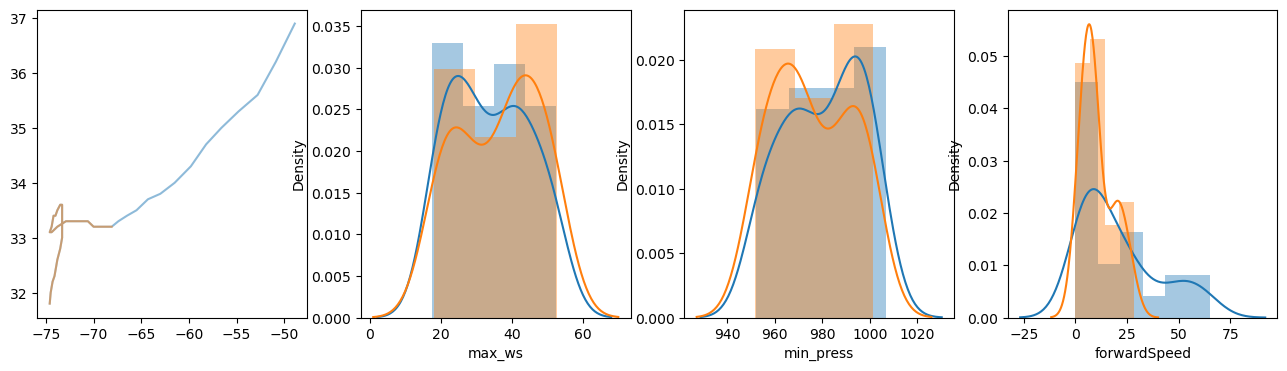

In [8]:
## read tracks from STORM files
## first set of runs of 01 considers the full track
pathStorm = Path(r'../data/STORM/processed/batch02')
dfIn = pd.read_pickle(pathStorm/'STORM_NA_R5_In_sortedMDA_shortened_dates_v3.pkl')

key = '0178'
dfInSub = dfIn[dfIn['runIndex'] == int(key)]
fig, ax = plt.subplots(figsize = (16, 4), ncols = 4)
ax[0].plot(dct[key]['lon'], dct[key]['lat'], alpha = 0.5)
ax[0].plot(dfInSub['lon'], dfInSub['lat'], alpha = 0.5)
sns.distplot(dct[key]['wind_speed'], ax = ax[1])
sns.distplot(dfInSub['max_ws'], ax = ax[1])
sns.distplot(dct[key]['pressure'], ax = ax[2])
sns.distplot(dfInSub['min_press'], ax = ax[2])
sns.distplot(dct[key]['forward_speed'], ax = ax[3])
sns.distplot(dfInSub['forwardSpeed'], ax = ax[3])

#### Read tides from base simulation

In [9]:
pathin = Path(r'../models/adcirc/concorde/batch02/_postprocessing')
baseNOAA = pd.read_csv(pathin/'time_series_water_level_at_NC_estuaries_closest_baseSim.csv', index_col = 0, parse_dates = True)
baseNOAA = baseNOAA.tz_localize(None)
baseDom = pd.read_csv(pathin/'time_series_water_level_at_domCenter_baseSim.csv', index_col = 0, parse_dates = True)
baseDom = baseDom.tz_localize(None)

baseNOAA['Boundary'] = baseDom.values.reshape(-1)
baseNOAA.head()

,Albemarle,Pamlico,Neuse,Boundary
2001-06-16 00:10:00,3.905989e-10,-1.280704e-09,1.144291e-09,6.041282e-08
2001-06-16 00:20:00,1.273533e-08,-2.699520e-09,-5.118926e-09,1.925880e-08
2001-06-16 00:30:00,3.761285e-08,-2.359329e-08,-3.367531e-08,2.066350e-05
2001-06-16 00:40:00,7.758787e-08,-6.501773e-08,-1.073545e-07,1.101777e-04
2001-06-16 00:50:00,1.301874e-07,-1.318658e-07,-2.391499e-07,2.169322e-04


<AxesSubplot: >

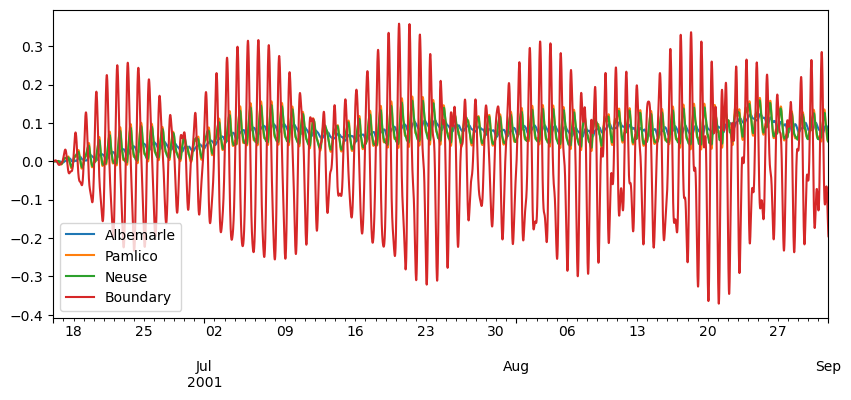

In [10]:
baseNOAA.plot(figsize = (10, 4))

#### Reduce length of the tracks ran in first iteration of batch 02

In [10]:
## get length of each fort.22
pathStorm = Path(r'../data/STORM/processed/batch02')
dfIn = pd.read_pickle(pathStorm/'STORM_NA_R5_In_sortedMDA_shortened_dates_v3.pkl')

lengths_tracks = []
for k in sorted(dfIn['runIndex'].unique()):
    l = len(dfIn[dfIn['runIndex'] == k])
    lengths_tracks.append(l)
dflStorm = pd.DataFrame({'length': lengths_tracks, 'run': dfIn['runIndex'].unique()})
dflStorm.head()

,length,run
0,39,0
1,46,1
2,48,2
3,27,3
4,24,4


In [11]:
pathin = Path(r'../models/adcirc/concorde/batch02/_postprocessing')
p01batch2 = pd.read_csv(pathin/'runs01_batch02.txt', header=None)
p01batch2['run'] = [x[:4] for x in p01batch2.iloc[:, 0]]
p01batch2.head()

,0,run
0,0000.tar.gz,0000
1,0002.tar.gz,0002
2,0003.tar.gz,0003
3,0004.tar.gz,0004
4,0007.tar.gz,0007


In [12]:
dct = pd.read_pickle(pathout/'dct_tracksAll_batch02_estuaries.pkl')

In [13]:
dctTracks = {}
distsAll = []
c1 = 0
c2 = 0
dummy = []
for ik, k in enumerate(dct.keys()):
    if k in p01batch2['run'].to_list():
        dfF22 = dct[k]
        dfStorm = dfIn[dfIn['runIndex'] == int(k)]
        difLen = len(dfF22) - len(dfStorm)
        if difLen > 0:
            c1 += 1
            dists = []
            for i in range(difLen):
                dfF22s = dfF22.iloc[i:len(dfStorm) + i]
                dist = np.sqrt((dfF22s['lon'].values - dfStorm['lon'].values)**2 + 
                                                (dfF22s['lat'].values - dfStorm['lat'].values)**2)
                dists.append(np.max(dist))

            j = np.argmin(dists)
            dfF22s = dfF22.iloc[j:len(dfStorm)+j]
            dctTracks[k] = dfF22s

            dist = np.sqrt((dfF22s['lon'].values - dfStorm['lon'].values)**2 + 
                                (dfF22s['lat'].values - dfStorm['lat'].values)**2)
            distsAll.append(dist)
            dummy.append(k)

        else:
            c2 += 1
            dctTracks[k] = dct[k]
    else:
        dctTracks[k] = dct[k]

with open(pathout/'dct_tracksAll_batch02_estuaries_lengthCorr.pkl', 'wb') as fout:
    pickle.dump(dct, fout)

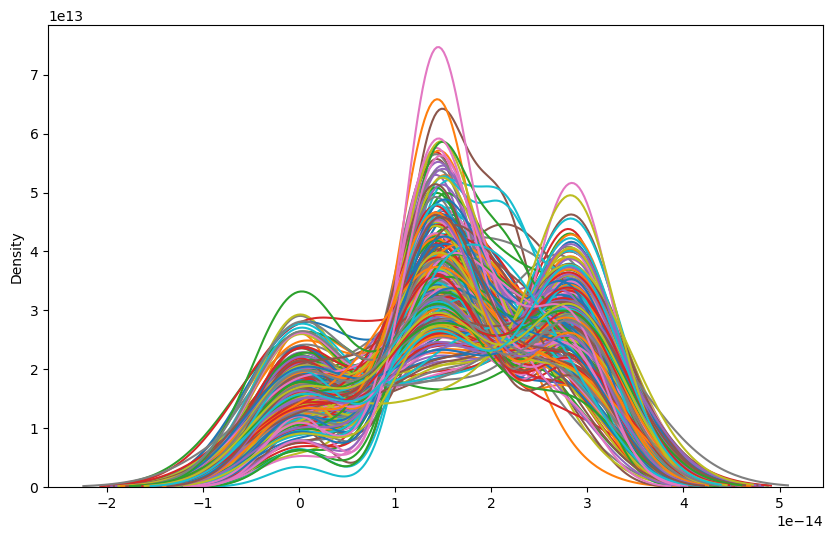

In [15]:
fig, ax = plt.subplots(figsize = (10, 6))
maxs = []
for k in distsAll:
    # maxs.append(np.max(k))
    sns.distplot(k, ax = ax, hist=False)

1134


<AxesSubplot: xlabel='forwardSpeed', ylabel='Density'>

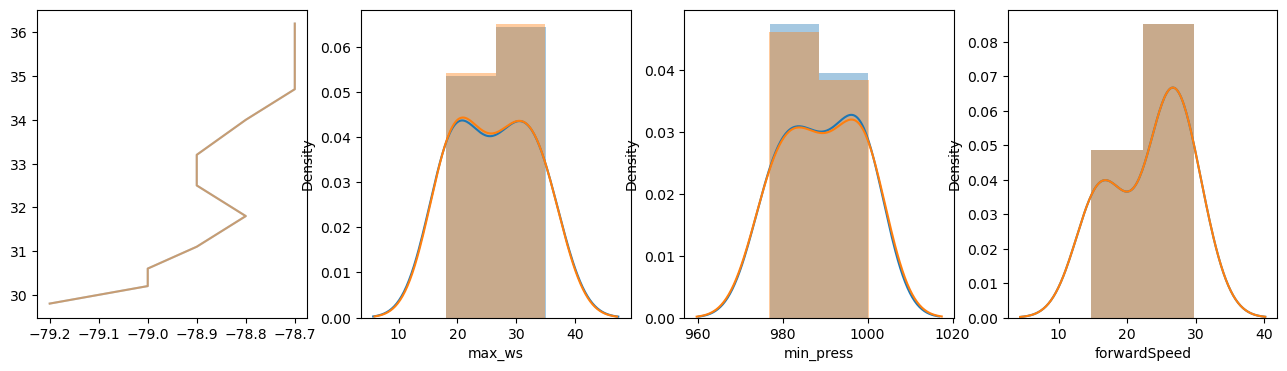

In [16]:
key = f'{np.random.randint(len(dctTracks.keys())):04d}'
# key = '0178'
print(key)
dfInSub = dfIn[dfIn['runIndex'] == int(key)]
fig, ax = plt.subplots(figsize = (16, 4), ncols = 4)
ax[0].plot(dctTracks[key]['lon'], dctTracks[key]['lat'], alpha = 0.5)
ax[0].plot(dfInSub['lon'], dfInSub['lat'], alpha = 0.5)
sns.distplot(dctTracks[key]['wind_speed'], ax = ax[1])
sns.distplot(dfInSub['max_ws'], ax = ax[1])
sns.distplot(dctTracks[key]['pressure'], ax = ax[2])
sns.distplot(dfInSub['min_press'], ax = ax[2])
sns.distplot(dctTracks[key]['forward_speed'], ax = ax[3])
sns.distplot(dfInSub['forwardSpeed'], ax = ax[3])

In [14]:
## get length of each fort.22
lengths = []
for k in sorted(dctTracks.keys()):
    l = len(dctTracks[k])
    lengths.append(l)
dfl = pd.DataFrame({'length': lengths, 'run': dct.keys()})
dfl.describe().T

,count,mean,std,min,25%,50%,75%,max
length,1813.0,33.974628,9.435585,10.0,27.0,37.0,40.0,79.0


### Merge track and tides

In [18]:
maxLength = dfl['length'].max()
print(maxLength)

79


In [15]:
dctInputRes = {}
for ik, k in enumerate(dctTracks.keys()):
    dfTrack = dctTracks[k]
    ## subset tide only base simulation
    dfTides = baseNOAA.loc[dfTrack.index[0]:dfTrack.index[-1], :]
    ## resample
    dfTrack_res = dfTrack.resample('1H').interpolate(method = 'linear')
    dfTides_res = dfTides.resample('1H').mean()
    ## fft of track data
    Xfft = np.abs(np.fft.fft(dfTrack_res.values, axis = 1))
    dfFFT = pd.DataFrame(index = dfTides_res.index, columns = [f'{col}_fft' for col in dfTrack_res.columns],
                         data = Xfft)

    dfInput = pd.concat([dfTrack_res, dfTides_res, dfFFT], axis = 1)
    dctInputRes[k] = dfInput

    if ik == 0:
        dfInput.to_csv(pathout/'dct_tracksAll_batch02_estuaries_lengthCorr_tides_resampled_SAMPLE.csv')

with open(pathout/'dct_tracksAll_batch02_estuaries_lengthCorr_tides_resampled.pkl', 'wb') as fout:
    pickle.dump(dctInputRes, fout)

In [16]:
## get length of each fort.22
lengths = []
for k in sorted(dctInputRes.keys()):
    l = len(dctInputRes[k])
    lengths.append(l)
dfl = pd.DataFrame({'length': lengths, 'run': dct.keys()})
dfl.describe().T

,count,mean,std,min,25%,50%,75%,max
length,1813.0,99.923883,28.306754,28.0,79.0,109.0,118.0,235.0


### Zero Padding

In [17]:
inpArrPadded = []
for k in dctInputRes.keys():
    aux = dctInputRes[k]
    padLength = dfl['length'].max() - len(aux)
    auxPadded = np.pad(aux.values, ((padLength, 0), (0, 0)), mode = 'constant')
    inpArrPadded.append(auxPadded)
inpArrPadded = np.asarray(inpArrPadded, dtype = float)

np.save(pathout/f'arr_tracksAll_batch02_estuaries_lengthCorr_tides_resampled.npy', inpArrPadded, allow_pickle=False)

In [18]:
inpArrPadded.shape

(1813, 235, 28)

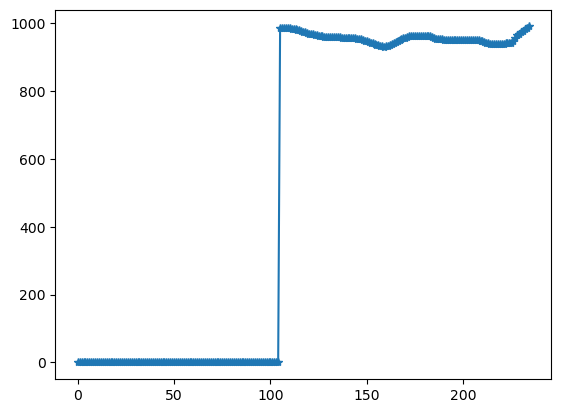

In [22]:
plt.plot(inpArrPadded[100, :, 3], marker = '*')

## Test train split

## Augment data

In [23]:
np.random.seed(42)

### Augment all storms

In [3]:
pathin = Path(r'../models/adcirc/concorde/batch02/_postprocessing/_preprocessForNN')
## data from fort.22
dctTracks = pd.read_pickle(pathin/'dct_tracksAll_batch02_estuaries_lengthCorr_tides_resampled.pkl')
## data from fort.63
dctWL = pd.read_pickle(pathin.parent/'time_series_water_level_at_NC_estuaries_closest.pkl')
## zero padded input array
inpArrPadded = np.load(pathin/f'arr_tracksAll_batch02_estuaries_lengthCorr_tides_resampled.npy')

## fort.63 of base simulation
baseNOAA = pd.read_csv(pathin.parent/'time_series_water_level_at_NC_estuaries_closest_baseSim.csv', index_col = 0, parse_dates = True)
baseNOAA = baseNOAA.tz_localize(None)
baseDom = pd.read_csv(pathin.parent/'time_series_water_level_at_domCenter_baseSim.csv', index_col = 0, parse_dates = True)
baseDom = baseDom.tz_localize(None)

baseNOAA['Boundary'] = baseDom.values.reshape(-1)

## read outputs
dfout = pd.read_csv(pathin.parent/'max_water_level_at_NC_NC_estuaries.csv', index_col = 0)
dfout = dfout.sort_index()
arrOut = dfout.values.reshape((dfout.shape[0], dfout.shape[1], 1))

In [4]:
dummy = []
for i, j in zip(dfout.index[1:], dfout.index[:-1]):
    if int(i) - int(j) != 1:
        dummy.append(int(i)-1)
        print(f'{i} and {j}')

624 and 622


In [5]:
aux = sorted(dctWL.keys())
dummy = []
for i, j in zip(aux[1:], aux[:-1]):
    if int(i) - int(j) != 1:
        dummy.append(int(i)-1)
        print(f'{i} and {j}')

0624 and 0622


In [6]:
augmented_inputs = []
augmented_outputs = []
nrep_per_storm = 50
for ik, k in tqdm(enumerate(dctTracks.keys())):
    track = dctTracks[k]
    dfWL = dctWL[k]
    dfWL = dfWL.tz_localize(None)
    ## intersect timestep with storm k and remove time series at model boundary
    dftide = baseNOAA.loc[baseNOAA.index.isin(dfWL.index), :].iloc[:, :-1]
    dfWL.columns = dftide.columns
    ## get only surge
    dfSurgeOnly = dfWL - dftide
    ## duration of storm 
    durSurge = dfSurgeOnly.index[-1] - dfSurgeOnly.index[0]
    ## last possible random start
    lastStart = baseNOAA.index[-1] - durSurge
    ixLastStart = baseNOAA.index.to_list().index(lastStart)
    ## random starting date ensuring all track time series is included in the new tide time series
    for r in range(nrep_per_storm):
        ixRandomStart = np.random.randint(0, ixLastStart)
        randomStart = baseNOAA.index[ixRandomStart]
        ## subset
        newTide = baseNOAA.loc[randomStart:randomStart+durSurge, :].resample('1H').mean()
        ## change dates
        newTide.index = dfWL.index
        ## new tide added to the surge only series after ramp
        newWL = (newTide.iloc[:, :-1] + dfSurgeOnly).loc[track.index[0]:, :]
        ## get max total water level
        maxNewWL = newWL.max(axis = 0)

        ## define zero padded input array as dataframe to replace new tide values
        inpArrCp = pd.DataFrame(inpArrPadded[ik, :, :])
        inpArrCp2 = inpArrCp.copy()
        ## change values
        inpArrCp2.iloc[-len(track):, 12:16] = newTide.loc[newTide.index.isin(track.index), :].values
        augmented_inputs.append(inpArrCp2.values)

        augmented_outputs.append(maxNewWL.values.reshape((maxNewWL.shape[0], 1)))

augmented_inputs = np.asarray(augmented_inputs)
augmented_outputs = np.asarray(augmented_outputs)

mergedInputs = np.concatenate([inpArrPadded, augmented_inputs], axis = 0)
mergedOutputs = np.concatenate([arrOut, augmented_outputs], axis = 0)

pathoutNN = Path(r'../models/NNmodel/inputs/random_split')

X_train, X_test, Y_train, Y_test, idx_train, idx_test = train_test_split(mergedInputs, mergedOutputs, range(mergedInputs.shape[0]),
                                                                         test_size=0.15, random_state=42, shuffle=True)

# scaler = MinMaxScaler()
scaler = StandardScaler()

X_train_res = X_train.reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2])
mask = X_train_res == 0
X_train_res[mask] = np.nan
X_train_sc = scaler.fit_transform(X_train_res)
X_train_sc = np.nan_to_num(X_train_sc, nan=-9999)
X_train_sc = X_train_sc.reshape(X_train.shape)
print(X_train_sc.shape)
print(Y_train.shape)

X_test_res = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])
mask = X_test_res == 0
X_test_res[mask] = np.nan
X_test_sc = scaler.transform(X_test_res)
X_test_sc = np.nan_to_num(X_test_sc, nan=-9999)
X_test_sc = X_test_sc.reshape(X_test.shape)
print(X_test_sc.shape)
print(Y_test.shape)

np.save(pathoutNN/f'X_train_standardScaled_allInputs_augmentedAllX{nrep_per_storm:02d}_estuaries.npy', X_train_sc, allow_pickle = False)
np.save(pathoutNN/f'y_train_augmentedAllX{nrep_per_storm:02d}_estuaries.npy', Y_train, allow_pickle = False)
np.save(pathoutNN/f'X_test_standardScaled_allInputs_augmentedAllX{nrep_per_storm:02d}_estuaries.npy', X_test_sc, allow_pickle = False)
np.save(pathoutNN/f'y_test_augmentedAllX{nrep_per_storm:02d}_estuaries.npy', Y_test, allow_pickle = False)
np.savetxt(pathoutNN/f'indices_train_standardScaled_allInputs_augmentedAllX{nrep_per_storm:02d}_estuaries.txt', idx_train, fmt='%d')
np.savetxt(pathoutNN/f'indices_test_standardScaled_allInputs_augmentedAllX{nrep_per_storm:02d}_estuaries.npy', idx_test, fmt='%d')

with open(pathoutNN/f'standarScaler_augmentedAllX{nrep_per_storm:02d}_estuaries.pkl', 'wb') as file:
    pickle.dump(scaler, file)

0it [00:00, ?it/s]

1813it [05:06,  5.91it/s]


: 

In [42]:
i

'0624'

In [43]:
j

'0622'